In [1]:
from opt_einsum.paths import branch_1
!apt-get update
!apt-get install graphviz -y

!pip install tensorflow
!pip install numpy
!pip install pandas

!pip install keras
!pip install scikit-learn
!pip install matplotlib
!pip install joblib
!pip install pyarrow
!pip install fastparquet
!pip install scipy
!pip install seaborn
!pip install tqdm
!pip install pydot
!pip install tensorflow-io
!pip install tensorflow-addons

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 121 not upgraded.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is av

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, MultiHeadAttention, Dropout, BatchNormalization, LayerNormalization, Input, Activation, Lambda, Bidirectional, Add, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D, \
    GlobalMaxPooling1D, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import json
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
import os
import joblib
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

folder_name = datetime.now().strftime("%Y-%m-%d_%H-%M")

random_state_value = None

2024-11-20 18:26:10.290667: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def get_season(date):
    month = date.month
    day = date.day
    if (month == 12 and day >= 21) or (month <= 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month <= 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or (month <= 12 and day < 21):
        return 'Autumn'
    else:
        return 'Unknown'


def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'


def add_time_features(df):
    """
    Add time-based features to the DataFrame.
    Works with both 'datetime' as column or index.
    """
    # Se datetime è l'indice, lo usiamo direttamente
    if isinstance(df.index, pd.DatetimeIndex):
        datetime_col = df.index
    else:
        # Se datetime è una colonna, la convertiamo
        if 'datetime' in df.columns:
            datetime_col = pd.to_datetime(df['datetime'])
        else:
            raise ValueError("No datetime column or index found in DataFrame")

    # Creazione delle feature temporali
    df['timestamp'] = datetime_col.astype(np.int64) // 10 ** 9
    df['year'] = datetime_col.year
    df['month'] = datetime_col.month
    df['day'] = datetime_col.day
    df['hour'] = datetime_col.hour
    df['minute'] = datetime_col.minute
    df['hour_sin'] = np.sin(datetime_col.hour * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(datetime_col.hour * (2 * np.pi / 24))
    df['day_of_week'] = datetime_col.dayofweek
    df['day_of_year'] = datetime_col.dayofyear
    df['week_of_year'] = datetime_col.isocalendar().week.astype(int)
    df['quarter'] = datetime_col.quarter
    df['is_month_end'] = datetime_col.is_month_end.astype(int)
    df['is_quarter_end'] = datetime_col.is_quarter_end.astype(int)
    df['is_year_end'] = datetime_col.is_year_end.astype(int)
    df['month_sin'] = np.sin(datetime_col.month * (2 * np.pi / 12))
    df['month_cos'] = np.cos(datetime_col.month * (2 * np.pi / 12))
    df['day_of_year_sin'] = np.sin(datetime_col.dayofyear * (2 * np.pi / 365.25))
    df['day_of_year_cos'] = np.cos(datetime_col.dayofyear * (2 * np.pi / 365.25))
    df['season'] = datetime_col.map(get_season)
    df['time_period'] = datetime_col.hour.map(get_time_period)

    return df


def add_solar_features(df):
    # Solar angle calculation
    df['solar_angle'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25)) * np.sin(df['hour'] * (2 * np.pi / 24))

    # Interactions between relevant features
    df['cloud_temp_interaction'] = df['cloudcover'] * df['temp']
    df['visibility_cloud_interaction'] = df['visibility'] * (100 - df['cloudcover'])

    # Derived features
    df['clear_sky_index'] = (100 - df['cloudcover']) / 100
    df['temp_gradient'] = df['temp'] - df['tempmin']

    return df


def add_solar_specific_features(df):
    """
    Aggiunge feature specifiche per la predizione della radiazione solare
    combinando caratteristiche astronomiche e meteorologiche
    """
    # Caratteristiche astronomiche
    df['day_length'] = 12 + 3 * np.sin(2 * np.pi * (df['day_of_year'] - 81) / 365.25)
    df['solar_noon'] = 12 - df['hour']
    df['solar_elevation'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25) * np.cos(2 * np.pi * df['solar_noon'] / 24)

    # Angolo solare teorico
    df['solar_angle'] = np.sin(df['hour_sin']) * np.sin(df['day_of_year_sin'])

    # Interazioni con condizioni atmosferiche
    df['cloud_elevation'] = df['cloudcover'] * df['solar_elevation']
    df['visibility_elevation'] = df['visibility'] * df['solar_elevation']
    df['uv_cloud_interaction'] = df['uvindex'] * (100 - df['cloudcover']) / 100

    # Indici di chiarezza e trasmissione
    df['clearness_index'] = (100 - df['cloudcover']) * df['visibility'] / 10000
    df['atmospheric_attenuation'] = (df['pressure'] / 1013.25) * (1 - (df['humidity'] / 100) * 0.6)

    # Radiazione teorica e attenuazione
    df['theoretical_radiation'] = df['solar_angle'].clip(0, 1) * 1000
    df['expected_radiation'] = df['theoretical_radiation'] * df['clearness_index']

    # Rolling features
    df['cloud_rolling_12h'] = df['cloudcover'].rolling(window=12).mean()
    df['temp_rolling_12h'] = df['temp'].rolling(window=12).mean()
    df['uv_rolling_12h'] = df['uvindex'].rolling(window=12).mean()

    # Interazioni temperatura-radiazione
    df['temp_radiation_potential'] = df['temp'] * df['solar_elevation']

    return df


def add_radiation_energy_features(df):
    """Adds specific features based on solarenergy and uvindex"""

    # Assicuriamoci che l'indice sia di tipo datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df['datetime'])

    # Solar energy to UV ratio (independent from solarradiation)
    df['energy_uv_ratio'] = df['solarenergy'] / (df['uvindex'] + 1e-6)

    # Time aggregations
    # Moving averages
    windows = [3, 6, 12, 24]  # hours
    for w in windows:
        df[f'energy_rolling_mean_{w}h'] = df['solarenergy'].rolling(window=w).mean()
        df[f'uv_rolling_mean_{w}h'] = df['uvindex'].rolling(window=w).mean()

    # Daily aggregations utilizzando datetime
    df['energy_daily_sum'] = df.groupby(df.index.date)['solarenergy'].transform('sum')
    df['uv_daily_max'] = df.groupby(df.index.date)['uvindex'].transform('max')

    # Changes
    df['energy_change'] = df['solarenergy'].diff()
    df['uv_change'] = df['uvindex'].diff()

    # Lag features
    lags = [1, 2, 3, 6, 12, 24]  # hours
    for lag in lags:
        df[f'energy_lag_{lag}h'] = df['solarenergy'].shift(lag)
        df[f'uv_lag_{lag}h'] = df['uvindex'].shift(lag)

    # Peak indicators
    df['is_energy_peak'] = (df['solarenergy'] > df['energy_rolling_mean_6h'] * 1.2).astype(int)
    df['is_uv_peak'] = (df['uvindex'] > df['uv_rolling_mean_6h'] * 1.2).astype(int)

    # Aggiungiamo alcune metriche di volatilità
    df['energy_volatility'] = df['energy_change'].rolling(window=24).std()
    df['uv_volatility'] = df['uv_change'].rolling(window=24).std()

    # Indice di intensità solare composito
    df['solar_intensity_index'] = (df['solarenergy'] * df['uvindex']) / (df['cloudcover'] + 1e-6)

    # Interazioni
    df['uv_cloud_interaction'] = df['uvindex'] * (100 - df['cloudcover']) / 100
    df['energy_temp_interaction'] = df['solarenergy'] * df['temp']

    return df


def add_advanced_features(df):
    """
    Add all advanced features to the DataFrame
    Assumes df has a DatetimeIndex
    """
    # Verifichiamo che abbiamo un DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")

    # Existing features
    df = add_time_features(df)
    df = add_solar_features(df)
    df = add_solar_specific_features(df)
    df = add_radiation_energy_features(df)

    # Weather variable interactions
    df['temp_humidity'] = df['temp'] * df['humidity']
    df['temp_cloudcover'] = df['temp'] * df['cloudcover']
    df['visibility_cloudcover'] = df['visibility'] * df['cloudcover']

    # Derived features
    df['clear_sky_factor'] = (100 - df['cloudcover']) / 100
    df['temp_humidity_interaction'] = df['temp'] * df['humidity'] / 100
    df['atmospheric_transparency'] = (100 - df['cloudcover']) * (df['visibility'] / 10)

    # Rolling means
    df['temp_rolling_mean_6h'] = df['temp'].rolling(window=6).mean()
    df['cloudcover_rolling_mean_6h'] = df['cloudcover'].rolling(window=6).mean()

    # Lag features
    df['temp_1h_lag'] = df['temp'].shift(1)
    df['cloudcover_1h_lag'] = df['cloudcover'].shift(1)
    df['humidity_1h_lag'] = df['humidity'].shift(1)

    # Extreme conditions indicator
    df['extreme_conditions'] = ((df['temp'] > df['temp'].quantile(0.75)) &
                                (df['humidity'] < df['humidity'].quantile(0.25))).astype(int)

    # One-hot encoding for categorical features
    df = pd.get_dummies(df, columns=['season', 'time_period'])

    return df


def prepare_advanced_data(df):
    """
    Prepare data for advanced modeling with proper datetime handling
    """
    # Assicuriamoci che abbiamo una copia del DataFrame
    df = df.copy()

    # Verifichiamo se datetime è già l'indice
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)
        else:
            raise ValueError("No datetime column or index found in DataFrame")

    # Ordiniamo il DataFrame per datetime
    df = df.sort_index()

    # Apply feature engineering functions
    df = add_advanced_features(df)

    #all_columns = list(df.columns)
    #print(all_columns)

    features = {
        # Primary Features (strong direct correlation)
        'primary_features': [
            'uvindex',  # Direct radiation indicator
            'cloudcover',  # Cloud coverage
            'visibility',  # Atmospheric transparency
            'temp',  # Temperature
            'pressure',  # Atmospheric pressure
            'humidity',  # Humidity
        ],

        # Astronomical and Temporal Features
        'astronomical_features': [
            'solar_elevation',  # Solar elevation
            'solar_angle',  # Solar angle
            'day_length',  # Day length
            'hour_sin',  # Daily cycle
            'hour_cos',
            'day_of_year_sin',  # Annual cycle
            'day_of_year_cos',
            'month_sin',  # Monthly cycle
            'month_cos',
        ],

        # Key Indices and Interactions
        'key_interactions': [
            'clear_sky_index',  # Clear sky index
            'atmospheric_attenuation',  # Atmospheric attenuation
            'theoretical_radiation',  # Theoretical radiation
            'expected_radiation',  # Expected radiation
            'cloud_elevation',  # Cloud-elevation interaction
            'visibility_elevation',  # Visibility-elevation interaction
            'uv_cloud_interaction',  # UV-cloud interaction
            'temp_radiation_potential',  # Temperature-radiation potential
        ],

        # Rolling Features (temporal trends)
        'rolling_features': [
            'cloud_rolling_12h',  # Cloud coverage moving average
            'temp_rolling_12h',  # Temperature moving average
            'uv_rolling_12h',  # UV moving average
            'cloudcover_rolling_mean_6h',
            'temp_rolling_mean_6h',
        ],

        # Lag Features (most recent)
        'lag_features': [
            'temp_1h_lag',  # 1-hour temperature lag
            'cloudcover_1h_lag',  # 1-hour cloud coverage lag
            'humidity_1h_lag',  # 1-hour humidity lag
            'uv_lag_1h',  # 1-hour UV lag
        ],

        # Categorical Features
        'categorical_features': [
            'season_Spring',  # Seasons
            'season_Summer',
            'season_Autumn',
            'season_Winter',
            'time_period_Morning',  # Time periods
            'time_period_Afternoon',
            'time_period_Evening',
            'time_period_Night',
        ]
    }

    final_features = [feature for group in features.values() for feature in group]

    # Handle missing values
    target_variables = ['solarradiation', 'solarenergy', 'uvindex']
    for column in final_features + target_variables:
        if column in df.columns:
            df[column] = df[column].interpolate(method='time')
    df.fillna(0, inplace=True)

    # Temporal split
    data_after_2010 = df[df['year'] >= 2010].copy()
    data_before_2010 = df[df['year'] < 2010].copy()

    X = data_after_2010[final_features]
    y = data_after_2010['solarradiation']
    X_to_predict = data_before_2010[final_features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )

    # Scaling
    feature_scaler = RobustScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    X_to_predict_scaled = feature_scaler.transform(X_to_predict)

    target_scaler = RobustScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Print info about selected features
    print("\nSelected features:")
    print(f"Number of features: {len(final_features)}")
    print("Features list:", final_features)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler, final_features, X_to_predict_scaled


def create_sequence_data(X, sequence_length=24):
    """
    Converts data into sequences for LSTM input
    sequence_length represents how many previous hours to consider
    """
    sequences = []
    for i in range(len(X) - sequence_length + 1):
        sequences.append(X[i:i + sequence_length])
    return np.array(sequences)


def prepare_hybrid_data(df):
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler, features, X_to_predict_scaled = prepare_advanced_data(df)

    # Convert data into sequences
    sequence_length = 24  # 24 hours of historical data

    X_train_seq = create_sequence_data(X_train_scaled, sequence_length)
    X_test_seq = create_sequence_data(X_test_scaled, sequence_length)

    # Adjust y by removing the first (sequence_length-1) elements
    y_train = y_train_scaled[sequence_length - 1:]
    y_test = y_test_scaled[sequence_length - 1:]

    X_to_predict_seq = create_sequence_data(X_to_predict_scaled, sequence_length)

    return X_train_seq, X_test_seq, y_train, y_test, feature_scaler, target_scaler, features, X_to_predict_seq

In [ ]:
def create_residual_lstm_layer(x, units, dropout_rate, l2_reg=0.01, return_sequences=True, survival_probability=0.8):
    """
    Creates a bidirectional LSTM layer with residual connections and regularization.

    Parameters:
        x: Input tensor
        units: Number of LSTM units
        dropout_rate: Dropout rate for regularization
        l2_reg: L2 regularization factor
        return_sequences: Whether to return sequences or just the last output
        survival_probability: Probability of layer survival for stochastic depth
    """
    residual = x
    x = Bidirectional(LSTM(units, return_sequences=return_sequences, kernel_regularizer=regularizers.l2(l2_reg)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)

    if return_sequences:
        if int(residual.shape[-1]) != 2 * units:
            residual = Dense(2 * units, activation='linear')(residual)
        x = tfa.layers.StochasticDepth(survival_probability)([x, residual])
    return x


def attention_block(x, units, num_heads=8, survival_probability=0.8):
    """
    Creates a multi-head attention block with residual connections.

    Parameters:
        x: Input tensor
        units: Dimension of the key space
        num_heads: Number of attention heads
        survival_probability: Probability of layer survival for stochastic depth
    """
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=units)(x, x)
    x = tfa.layers.StochasticDepth(survival_probability)([x, attention])
    x = LayerNormalization()(x)
    return x


def create_solarradiation_model(input_shape, folder_name, l2_lambda=0.005, min_output=0, max_output=1):
    """
    Creates a deep learning model for solar radiation prediction using LSTM and attention mechanisms.

    Parameters:
        input_shape: Shape of input data
        folder_name: Directory to save model architecture visualization
        l2_lambda: L2 regularization factor
    """
    inputs = Input(shape=input_shape)

    # Progressive hyperparameters for model architecture
    survival_probs = [0.9, 0.8, 0.7, 0.6]  # Decreasing survival probabilities for deeper layers
    attention_survival_probs = [0.85, 0.75, 0.65, 0.55]  # Survival probabilities for attention blocks
    lstm_units = [256, 128, 64, 32]  # Decreasing number of units for LSTM layers
    dropout_rates = [0.4, 0.3, 0.2, 0.2]  # Decreasing dropout rates
    attention_heads = [32, 24, 16, 8]  # Decreasing number of attention heads

    lstm_blocks = 4
    # Main network architecture
    x = inputs
    for i in range(lstm_blocks):
        # LSTM layer with residual connections
        x = create_residual_lstm_layer(
            x,
            units=lstm_units[i],
            dropout_rate=dropout_rates[i],
            l2_reg=l2_lambda,
            return_sequences=True,
            survival_probability=survival_probs[i]
        )
        # Attention block
        x = attention_block(
            x,
            units=lstm_units[i],
            num_heads=attention_heads[i],
            survival_probability=attention_survival_probs[i]
        )
        if i < lstm_blocks - 1:  # No pooling after last LSTM layer
            x = MaxPooling1D()(x)

    # Final LSTM layer for sequence aggregation
    x = create_residual_lstm_layer(
        x,
        units=32,
        dropout_rate=0.1,
        l2_reg=l2_lambda,
        return_sequences=False,
        survival_probability=0.6
    )

    # Dense layers for final prediction
    dense_units = [128, 64, 32]
    dense_dropout = [0.2, 0.1, 0.05]

    for units, dropout in zip(dense_units, dense_dropout):
        x = Dense(units, kernel_regularizer=regularizers.l2(l2_lambda))(x)
        x = BatchNormalization()(x)
        x = Activation('swish')(x)
        x = Dropout(dropout)(x)

    # Output layer with value clipping
    outputs = Dense(1)(x)
    outputs = Lambda(lambda x: tf.clip_by_value(x, min_output, max_output))(outputs)

    # Model compilation
    model = Model(inputs=inputs, outputs=outputs, name="SolarRadiationModel")

    # Improved loss function
    def hybrid_focal_loss(y_true, y_pred):
        # MSE with focal weighting
        mse = tf.square(y_true - y_pred)
        error_ratio = tf.abs(y_true - y_pred) / (tf.abs(y_true) + 1.0)
        focal_weight = tf.pow(error_ratio, 2)
        weighted_mse = focal_weight * mse

        # MAE component
        mae = tf.abs(y_true - y_pred)

        return tf.reduce_mean(0.7 * weighted_mse + 0.3 * mae)

    # Custom metrics
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    def custom_mape(y_true, y_pred):
        epsilon = 1e-7
        diff = tf.abs((y_true - y_pred) / (y_true + epsilon))
        diff = tf.clip_by_value(diff, 0, 1)
        return tf.reduce_mean(diff) * 100

    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=0.0003,
        first_decay_steps=1000,
        t_mul=2.0,
        m_mul=0.9,
        alpha=1e-5
    )

    # Optimizer
    optimizer = AdamW(
        learning_rate=lr_schedule,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        weight_decay=0.001,
        amsgrad=True
    )

    model.compile(
        optimizer=optimizer,
        loss=hybrid_focal_loss,
        metrics=['mse', 'mae', rmse, custom_mape]
    )

    model.summary()

    plot_model(model,
               to_file=f'{folder_name}_model_architecture.png',
               show_shapes=True,
               show_layer_names=True,
               dpi=150,
               show_layer_activations=True)

    return model


def evaluate_solarradiation_predictions(y_true, y_pred, hour=None, folder_name=None):
    """
    Comprehensive evaluation of solar radiation predictions with detailed analysis and visualizations.

    Parameters:
    -----------
    y_true : array-like
        Actual solar radiation values (W/m²)
    y_pred : array-like
        Predicted solar radiation values (W/m²)
    hour : array-like, optional
        Array of hours corresponding to predictions, for temporal analysis
    folder_name : str, optional
        Directory to save analysis plots

    Returns:
    --------
    dict
        Dictionary containing all calculated metrics
    """

    # Data preparation
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    errors = y_pred - y_true

    # Basic metrics calculation
    mae_raw = mean_absolute_error(y_true, y_pred)
    rmse_raw = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_raw = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-7))) * 100

    # Error margin accuracy
    within_5_percent = np.mean(np.abs((y_pred - y_true) / (y_true + 1e-7)) <= 0.05)
    within_10_percent = np.mean(np.abs((y_pred - y_true) / (y_true + 1e-7)) <= 0.10)
    within_20_percent = np.mean(np.abs((y_pred - y_true) / (y_true + 1e-7)) <= 0.20)

    # Radiation level classification
    def get_radiation_level(value):
        if value <= 200:
            return 'Very Low'
        elif value <= 400:
            return 'Low'
        elif value <= 600:
            return 'Moderate'
        elif value <= 800:
            return 'High'
        elif value <= 1000:
            return 'Very High'
        else:
            return 'Extreme'

    # Calculate radiation levels
    y_true_levels = [get_radiation_level(v) for v in y_true]
    y_pred_levels = [get_radiation_level(v) for v in y_pred]
    level_accuracy = np.mean([t == p for t, p in zip(y_true_levels, y_pred_levels)])

    # Print main metrics
    print("\nSolar Radiation Prediction Metrics:")
    print("\nAbsolute Metrics:")
    print(f"MAE: {mae_raw:.2f} W/m²")
    print(f"RMSE: {rmse_raw:.2f} W/m²")
    print(f"R² Score: {r2_raw:.3f}")
    print(f"MAPE: {mape:.2f}%")

    print("\nPercentage Accuracy:")
    print(f"Within ±5%: {within_5_percent * 100:.1f}%")
    print(f"Within ±10%: {within_10_percent * 100:.1f}%")
    print(f"Within ±20%: {within_20_percent * 100:.1f}%")

    print("\nLevel Accuracy:")
    print(f"Level Accuracy: {level_accuracy * 100:.1f}%")

    # Confusion matrix for radiation levels
    cm = confusion_matrix(y_true_levels, y_pred_levels)
    print("\nConfusion Matrix for Radiation Levels:")
    cm_df = pd.DataFrame(
        cm,
        columns=['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Extreme'],
        index=['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Extreme']
    )
    print(cm_df)

    # Time period analysis
    if hour is not None:
        day_periods = {
            'Morning (5-11)': (5, 11),
            'Noon (11-13)': (11, 13),
            'Afternoon (13-17)': (13, 17),
            'Evening (17-21)': (17, 21),
            'Night (21-5)': (21, 5)
        }

        print("\nAnalysis by Time Period:")
        for period, (start, end) in day_periods.items():
            if start < end:
                mask = (hour >= start) & (hour < end)
            else:
                mask = (hour >= start) | (hour < end)

            if np.any(mask):
                period_mae = mean_absolute_error(y_true[mask], y_pred[mask])
                period_mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-7))) * 100
                print(f"\n{period}:")
                print(f"MAE: {period_mae:.2f} W/m²")
                print(f"MAPE: {period_mape:.2f}%")

    # Visualizations
    if folder_name is not None:
        try:

            # Figure 1: Main analysis plots
            plt.figure(figsize=(20, 15))

            # Plot 1: Scatter plot of actual vs predicted values
            plt.subplot(3, 2, 1)
            plt.scatter(y_true, y_pred, alpha=0.5)
            plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
            plt.xlabel('Actual Radiation (W/m²)')
            plt.ylabel('Predicted Radiation (W/m²)')
            plt.title('Actual vs Predicted Values')
            plt.grid(True)

            # Plot 2: Absolute error distribution
            plt.subplot(3, 2, 2)
            plt.hist(errors, bins=50, alpha=0.7)
            plt.xlabel('Prediction Error (W/m²)')
            plt.ylabel('Frequency')
            plt.title('Error Distribution')
            plt.grid(True)

            # Plot 3: Percentage error distribution
            plt.subplot(3, 2, 3)
            percentage_errors = ((y_pred - y_true) / (y_true + 1e-7)) * 100
            plt.hist(np.clip(percentage_errors, -100, 100), bins=50, alpha=0.7)
            plt.xlabel('Percentage Error (%)')
            plt.ylabel('Frequency')
            plt.title('Percentage Error Distribution')
            plt.grid(True)

            # Plot 4: Errors vs actual values
            plt.subplot(3, 2, 4)
            plt.scatter(y_true, errors, alpha=0.5)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.xlabel('Actual Radiation (W/m²)')
            plt.ylabel('Error (W/m²)')
            plt.title('Errors vs Actual Values')
            plt.grid(True)

            # Plot 5: Error boxplot by radiation level
            plt.subplot(3, 2, 5)
            sns.boxplot(x=[get_radiation_level(v) for v in y_true], y=errors)
            plt.xticks(rotation=45)
            plt.xlabel('Radiation Level')
            plt.ylabel('Error (W/m²)')
            plt.title('Error Distribution by Level')

            # Plot 6: Confusion matrix heatmap
            plt.subplot(3, 2, 6)
            sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xticks(rotation=45)
            plt.yticks(rotation=45)

            plt.tight_layout()
            filename = f'{folder_name}_radiation_analysis.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot saved as: {filename}")
            plt.close()

        except Exception as e:
            print(f"\nError saving plots: {str(e)}")

    # Additional error statistics
    print("\nError Statistics:")
    print(f"Mean error: {np.mean(errors):.3f}")
    print(f"Error standard deviation: {np.std(errors):.3f}")
    print(f"Median error: {np.median(errors):.3f}")
    print(f"95th percentile absolute error: {np.percentile(np.abs(errors), 95):.3f}")

    # Return structured metrics
    metrics = {
        'absolute': {
            'mae': mae_raw,
            'rmse': rmse_raw,
            'r2': r2_raw,
            'mape': mape
        },
        'percentage_accuracy': {
            'within_5_percent': within_5_percent,
            'within_10_percent': within_10_percent,
            'within_20_percent': within_20_percent
        },
        'categorical': {
            'level_accuracy': level_accuracy
        },
        'error_stats': {
            'mean': float(np.mean(errors)),
            'std': float(np.std(errors)),
            'median': float(np.median(errors)),
            'p95_abs': float(np.percentile(np.abs(errors), 95))
        }
    }

    return metrics


def plot_training_history(history, folder_name=None):
    """
    Visualize and save training loss and metrics plots

    Parameters:
    -----------
    history : tensorflow.keras.callbacks.History
        History object returned by model training
    folder_name : str
        Directory to save the plots and metrics
    """

    try:
        # Create figure
        plt.figure(figsize=(12, 4))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # MAE plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()

        if folder_name is not None:
            # Generate filename with timestamp
            filename = f'{folder_name}_training_history.png'  # Rimossa parentesi extra

            # Save figure
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nTraining history plot saved as: {filename}")

        # Save numerical data in CSV format
        history_df = pd.DataFrame({
            'epoch': range(1, len(history.history['loss']) + 1),
            'training_loss': history.history['loss'],
            'validation_loss': history.history['val_loss'],
            'training_mae': history.history['mae'],
            'validation_mae': history.history['val_mae']})

        if folder_name is not None:
            csv_filename = f'{folder_name}_training_history.csv'  # Rimossa parentesi extra
            history_df.to_csv(csv_filename, index=False)
            print(f"Training history data saved as: {csv_filename}")

        # Calculate and save final statistics
        final_stats = {
            'final_training_loss': history.history['loss'][-1],
            'final_validation_loss': history.history['val_loss'][-1],
            'final_training_mae': history.history['mae'][-1],
            'final_validation_mae': history.history['val_mae'][-1],
            'best_validation_loss': min(history.history['val_loss']),
            'best_validation_mae': min(history.history['val_mae']),
            'epochs': len(history.history['loss']),
        }

        if folder_name is not None:
            # Save statistics in JSON format
            stats_filename = f'{folder_name}_training_stats.json'  # Rimossa parentesi extra
            with open(stats_filename, 'w') as f:
                json.dump(final_stats, f, indent=4)
            print(f"Final statistics saved as: {stats_filename}")

        # Print main statistics
        print("\nFinal Training Statistics:")
        print(f"Final Loss (train/val): {final_stats['final_training_loss']:.4f}/{final_stats['final_validation_loss']:.4f}")
        print(f"Final MAE (train/val): {final_stats['final_training_mae']:.4f}/{final_stats['final_validation_mae']:.4f}")
        print(f"Best validation loss: {final_stats['best_validation_loss']:.4f}")
        print(f"Best validation MAE: {final_stats['best_validation_mae']:.4f}")

        plt.show()

    except Exception as e:
        print(f"\nError during plot creation or saving: {str(e)}")


def train_hybrid_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, folder_name='solarradiation'):
    """
    Advanced training function for the hybrid solar radiation model
    """

    def calculate_metrics(y_true, y_pred):
        """Helper function to calculate metrics safely"""
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()

        # Count out of range predictions
        out_of_range = np.sum((y_pred < 0) | (y_pred > 1500))

        # Calculate MAPE with clipping to avoid extreme values
        diff = np.abs((y_true - y_pred) / (y_true + 1e-7))
        diff = np.clip(diff, 0, 1)  # Clip to maximum 100% error
        mape = np.mean(diff) * 100

        # Calculate accuracy within 10%
        within_10_percent = np.mean(diff <= 0.10) * 100

        # Calculate MAE and RMSE
        mae = np.mean(np.abs(y_true - y_pred))
        rmse = np.sqrt(np.mean(np.square(y_true - y_pred)))

        return out_of_range, mape, within_10_percent, mae, rmse

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            mode='min',
            verbose=1,
            min_delta=1e-4
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            verbose=1,
            mode='min',
            min_delta=1e-4,
            cooldown=3,
            min_lr=1e-7
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'{folder_name}_best_model.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            save_weights_only=False
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./{folder_name}_logs',
            histogram_freq=1,
            write_graph=True,
            update_freq='epoch'
        ),
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: (
                    print(f"\nEpoch {epoch + 1} Detailed Metrics:") and
                    (lambda: (
                        y_pred := model.predict(X_test, verbose=0),
                        metrics := calculate_metrics(y_test, y_pred),
                        print(f"Out of range: {metrics[0]} predictions"),
                        print(f"MAPE: {metrics[1]:.2f}%"),
                        print(f"Within ±10%: {metrics[2]:.2f}%"),
                        print(f"MAE: {metrics[3]:.2f}"),
                        print(f"RMSE: {metrics[4]:.2f}")
                    ))()
            ) if epoch % 5 == 0 else None
        )
    ]

    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1,
            shuffle=False
        )

        print("\nTraining completed successfully!")

        # Final evaluation
        final_pred = model.predict(X_test, verbose=0)
        metrics = calculate_metrics(y_test, final_pred)

        print("\nFinal Model Performance:")
        print(f"Out of range predictions: {metrics[0]} ({metrics[0] / len(y_test) * 100:.2f}%)")
        print(f"MAPE: {metrics[1]:.2f}%")
        print(f"Predictions within ±10%: {metrics[2]:.2f}%")
        print(f"MAE: {metrics[3]:.2f}")
        print(f"RMSE: {metrics[4]:.2f}")

        plot_training_history(history, folder_name=folder_name)

        return history

    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

    finally:
        tf.keras.backend.clear_session()


def integrate_predictions(df, predictions, sequence_length=24):
    """
    Integrates solar radiation predictions into the original dataset for pre-2010 data.

    Parameters:
    -----------
    df : pandas.DataFrame
        Original dataset
    predictions : numpy.ndarray
        Array of solar radiation predictions
    sequence_length : int
        Sequence length used for predictions

    Returns:
    --------
    pandas.DataFrame
        Updated dataset with solar radiation predictions
    """
    # Convert datetime to datetime format if not already
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Identify pre-2010 rows
    mask_pre_2010 = df['datetime'].dt.year < 2010

    # Create temporary DataFrame with predictions
    dates_pre_2010 = df[mask_pre_2010]['datetime'].iloc[sequence_length - 1:]
    predictions_df = pd.DataFrame({
        'datetime': dates_pre_2010,
        'solarradiation_predicted': predictions.flatten()})

    # Merge with original dataset
    df = df.merge(predictions_df, on='datetime', how='left')

    # Update solar radiation column where missing
    df['solarradiation'] = df['solarradiation'].fillna(df['solarradiation_predicted'])

    # Remove temporary column
    df = df.drop('solarradiation_predicted', axis=1)

    print(f"Added {len(predictions)} predictions to dataset")
    print(f"Rows with solar radiation after integration: {df['solarradiation'].notna().sum()}")

    return df

In [5]:
df = pd.read_parquet('../../sources/weather_data_uvindex.parquet')

print("Initializing solar radiation model training...")

# Data preparation
print("\n1. Preparing data...")
X_train_seq, X_test_seq, y_train, y_test, feature_scaler, target_scaler, features, X_to_predict_seq = prepare_hybrid_data(df)

print(f"Training data shape: {X_train_seq.shape}")
print(f"Test data shape: {X_test_seq.shape}")

# Save or load scaler and features
feature_scaler_path = f'{folder_name}_scale_X.joblib'
target_scaler_path = f'{folder_name}_scale_y.joblib'
features_path = f'{folder_name}_features.json'
model_path = f'{folder_name}_best_model.h5'
history_path = f'{folder_name}_training_history.json'

if os.path.exists(feature_scaler_path):
    print(f"Loading existing scaler X from: {feature_scaler_path}")
    scaler = joblib.load(feature_scaler_path)
else:
    print(f"Saving scaler X to: {feature_scaler_path}")
    joblib.dump(feature_scaler, feature_scaler_path)

if os.path.exists(target_scaler_path):
    print(f"Loading existing scaler X from: {target_scaler_path}")
    scaler = joblib.load(target_scaler_path)
else:
    print(f"Saving scaler X to: {target_scaler_path}")
    joblib.dump(target_scaler, target_scaler_path)

if os.path.exists(features_path):
    print(f"Loading existing features from: {features_path}")
    with open(features_path, 'r') as f:
        features = json.load(f)
else:
    print(f"Saving features to: {features_path}")
    with open(features_path, 'w') as f:
        json.dump(features, f)

# Data quality verification
if np.isnan(X_train_seq).any() or np.isnan(y_train).any():
    raise ValueError("Found NaN values in training data")

Initializing solar radiation model training...

1. Preparing data...

Selected features:
Number of features: 40
Features list: ['uvindex', 'cloudcover', 'visibility', 'temp', 'pressure', 'humidity', 'solar_elevation', 'solar_angle', 'day_length', 'hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos', 'clear_sky_index', 'atmospheric_attenuation', 'theoretical_radiation', 'expected_radiation', 'cloud_elevation', 'visibility_elevation', 'uv_cloud_interaction', 'temp_radiation_potential', 'cloud_rolling_12h', 'temp_rolling_12h', 'uv_rolling_12h', 'cloudcover_rolling_mean_6h', 'temp_rolling_mean_6h', 'temp_1h_lag', 'cloudcover_1h_lag', 'humidity_1h_lag', 'uv_lag_1h', 'season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter', 'time_period_Morning', 'time_period_Afternoon', 'time_period_Evening', 'time_period_Night']
Training data shape: (103798, 24, 40)
Test data shape: (25933, 24, 40)



2. Creating model...


2024-11-20 18:26:58.091461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43404 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:a1:00.0, compute capability: 8.9


Model: "SolarRadiationModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 40)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 24, 512)              608256    ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 layer_normalization (Layer  (None, 24, 512)              1024      ['bidirectional[0][0]']       
 Normalization)                                                                                   
                                                                                

2024-11-20 18:28:08.462396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-20 18:28:08.551588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-11-20 18:28:08.771296: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7494b4d65840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-20 18:28:08.771333: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
2024-11-20 18:28:08.779091: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-20 18:28:08.849938: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-20 18:28:08.914097: I ./tensor

810/811 [============================>.] - ETA: 0s - loss: 72528.1172 - mse: 106644.4453 - mae: 187.8485 - rmse: 303.3813 - custom_mape: 54.8740

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1 Detailed Metrics:
811/811 [==============================] - 59s 47ms/step - loss: 72456.4219 - mse: 106540.3906 - mae: 187.7001 - rmse: 303.1588 - custom_mape: 54.8602 - val_loss: 65954.8828 - val_mse: 98078.7031 - val_mae: 177.0511 - val_rmse: 289.9380 - val_custom_mape: 52.7771 - lr: 2.5941e-05
Epoch 2/100
811/811 [==============================] - 35s 43ms/step - loss: 69535.9297 - mse: 104347.7812 - mae: 185.7435 - rmse: 299.4631 - custom_mape: 53.3868 - val_loss: 63015.7383 - val_mse: 95844.1562 - val_mae: 175.0045 - val_rmse: 286.3577 - val_custom_mape: 52.6138 - lr: 2.1071e-04
Epoch 3/100
811/811 [==============================] - 34s 42ms/step - loss: 65040.6328 - mse: 100867.1875 - mae: 182.4250 - rmse: 293.5602 - custom_mape: 52.5410 - val_loss: 56593.6914 - val_mse: 90806.5000 - val_mae: 170.5536 - val_rmse: 278.2007 - val_custom_mape: 51.3653 - lr: 5.0264e-05
Epoch 4/100
811/811 [==============================] - 35s 43ms/step - loss: 63179.4570 - mse: 99390.6328 

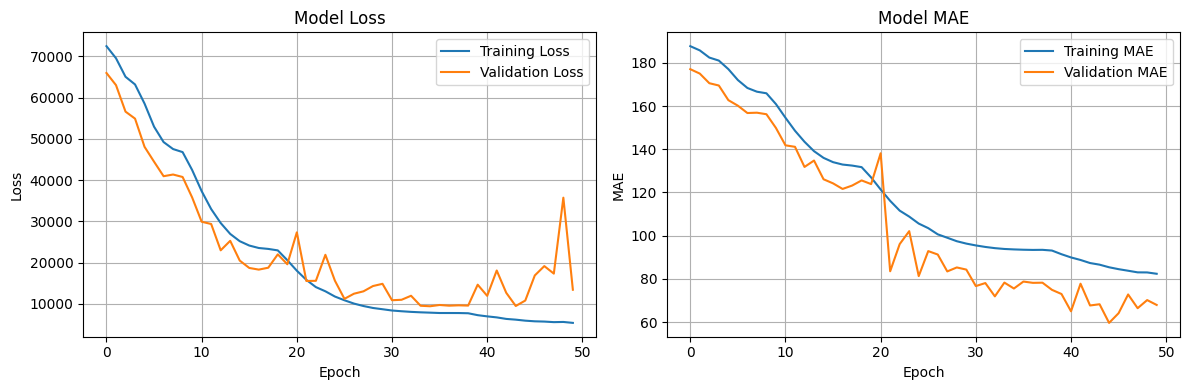

In [6]:
# Model creation
print("\n2. Creating model...")
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

MAX_RADIATION = 885

min_val_scaled = target_scaler.transform([[0]])[0][0]
max_val_scaled = target_scaler.transform([[MAX_RADIATION]])[0][0]

model = create_solarradiation_model(input_shape=input_shape, folder_name=folder_name, min_output=min_val_scaled, max_output=max_val_scaled)

print("\n4. Starting training...")
history = train_hybrid_model(
    model=model,
    X_train=X_train_seq,
    y_train=y_train,
    X_test=X_test_seq,
    y_test=y_test,
    epochs=100,
    batch_size=192,
    folder_name=folder_name
)

In [7]:
print("\n5. Generating predictions...")
predictions = model.predict(X_test_seq)
predictions = np.clip(predictions, 0, 11)

predictions_original = target_scaler.inverse_transform(predictions)
y_test_original = target_scaler.inverse_transform(y_test)

print("\n6. Evaluating model...")
metrics = evaluate_solarradiation_predictions(y_test_original, predictions_original, folder_name=folder_name)

# Create results dictionary
training_results = {
    'model_params': {
        'input_shape': input_shape,
        'n_features': len(features),
        'sequence_length': X_train_seq.shape[1]
    },
    'training_params': {
        'batch_size': 32,
        'total_epochs': len(history.history['loss']),
        'best_epoch': np.argmin(history.history['val_loss']) + 1
    },
    'performance_metrics': {
        'final_loss': float(history.history['val_loss'][-1]),
        'final_mae': float(history.history['val_mae'][-1]),
        'best_val_loss': float(min(history.history['val_loss'])),
        'out_of_range_predictions': int(np.sum((predictions < 0) | (predictions > 11)))
    }
}


5. Generating predictions...
811/811 [==============================] - 5s 6ms/step

6. Evaluating model...

Solar Radiation Prediction Metrics:

Absolute Metrics:
MAE: 175.39 W/m²
RMSE: 313.03 W/m²
R² Score: -0.413
MAPE: 9983339.55%

Percentage Accuracy:
Within ±5%: 46.6%
Within ±10%: 46.6%
Within ±20%: 46.6%

Level Accuracy:
Level Accuracy: 68.7%

Confusion Matrix for Radiation Levels:
           Very Low  Low  Moderate  High  Very High  Extreme
Very Low          0    0         0     0          0       10
Low               0    0         0     0          0     1827
Moderate          0    0         0     0          0     2861
High              0    0         0     0          0     2296
Very High         0    0         0     0          0     1131
Extreme           0    0         0     0          0    17808

Plot saved as: 2024-11-20_18-26_radiation_analysis.png

Error Statistics:
Mean error: -175.370
Error standard deviation: 259.295
Median error: -12.000
95th percentile absolute erro

In [9]:
print("\n7. Predicting missing data...")
to_predict_predictions = model.predict(X_to_predict_seq)
to_predict_predictions = np.clip(to_predict_predictions, 0, 11)

print("\n8. Integrating predictions into original dataset...")
df_updated = integrate_predictions(df.copy(), to_predict_predictions)

df_updated.to_parquet('../../sources/weather_data_solarradiation.parquet')

# Add prediction statistics to training_results
training_results['prediction_stats'] = {
    'n_predictions_added': len(to_predict_predictions),
    'mean_predicted_solarradiation': float(to_predict_predictions.mean()),
    'min_predicted_solarradiation': float(to_predict_predictions.min()),
    'max_predicted_solarradiation': float(to_predict_predictions.max()),
}

print("\nTraining completed successfully!")

tf.keras.backend.clear_session()


7. Predicting missing data...
7122/7122 [==============================] - 42s 6ms/step

8. Integrating predictions into original dataset...
Added 227879 predictions to dataset
Rows with solar radiation after integration: 357615

Training completed successfully!



Plot saved as: 2024-11-20_18-26_error_analysis.png


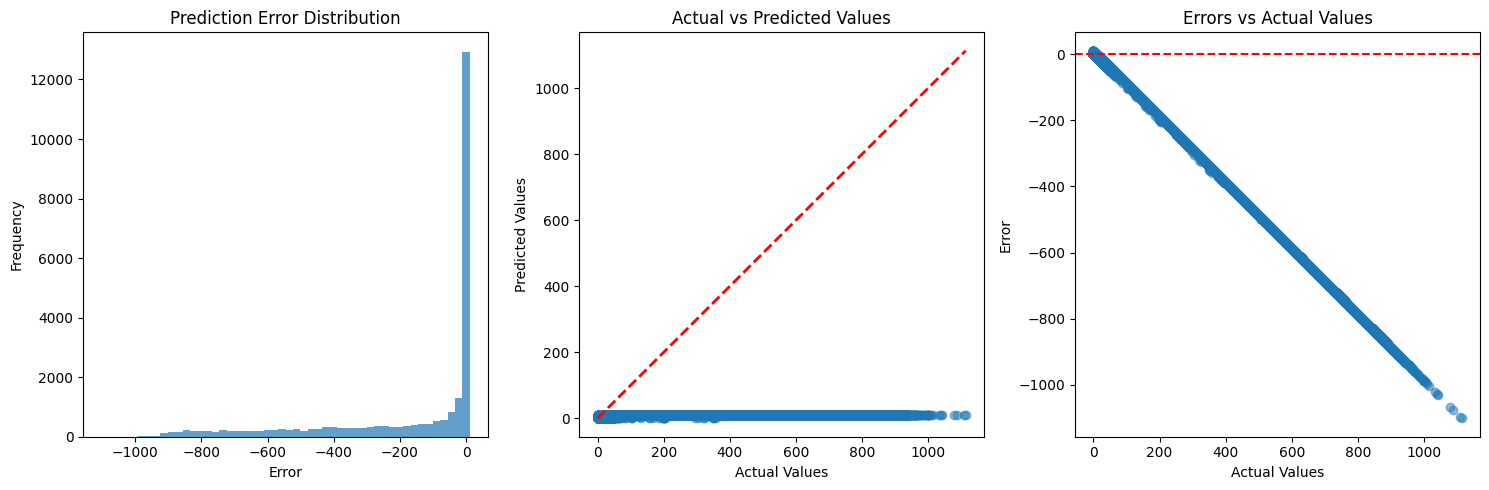


Error Statistics:
MAE: 175.3912
MSE: 97988.2659
RMSE: 313.0308
Mean error: -175.3699
Error std: 259.2946
Predictions within ±0.5: 46.6%
Predictions within ±1.0: 47.0%
Predictions within ±1.5: 47.0%
Predictions within ±2.0: 47.2%


In [10]:
def plot_error_analysis(y_true, y_pred, folder_name=None):
    """
    Function to visualize prediction error analysis

    Parameters:
    -----------
    y_true : array-like
        Actual values
    y_pred : array-like
        Predicted values
    folder_name : str, optional
        Directory to save plots. If None, plots are only displayed

    Generates:
    ----------
    - Error distribution histogram
    - Actual vs Predicted scatter plot
    - Errors vs Actual Values scatter plot
    - Comprehensive error statistics
    """

    # Convert to 1D numpy arrays if needed
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # Calculate errors
    errors = y_pred - y_true

    # Create main figure
    fig = plt.figure(figsize=(15, 5))

    # Plot 1: Error Distribution
    plt.subplot(1, 3, 1)
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    # Plot 2: Actual vs Predicted
    plt.subplot(1, 3, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plot 3: Errors vs Actual Values
    plt.subplot(1, 3, 3)
    plt.scatter(y_true, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Errors vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Error')

    plt.tight_layout()

    # Save plot if directory is specified
    if folder_name is not None:
        try:
            # Create directory if it doesn't exist
            filename = f'{folder_name}_error_analysis.png'

            # Save figure
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot saved as: {filename}")
        except Exception as e:
            print(f"\nError saving plot: {str(e)}")

    plt.show()

    # Print error statistics
    print("\nError Statistics:")
    print(f"MAE: {np.mean(np.abs(errors)):.4f}")
    print(f"MSE: {np.mean(errors ** 2):.4f}")
    print(f"RMSE: {np.sqrt(np.mean(errors ** 2)):.4f}")
    print(f"Mean error: {np.mean(errors):.4f}")
    print(f"Error std: {np.std(errors):.4f}")

    # Calculate percentage of errors within thresholds
    thresholds = [0.5, 1.0, 1.5, 2.0]
    for threshold in thresholds:
        within_threshold = np.mean(np.abs(errors) <= threshold) * 100
        print(f"Predictions within ±{threshold}: {within_threshold:.1f}%")


# Example usage
plot_error_analysis(y_test, predictions, folder_name=folder_name)